In [1]:
from __future__ import annotations

import json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.datasets import load_digits
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import (
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)
ARTIFACTS_DIR = Path("artifacts")
ARTIFACTS_DIR.mkdir(parents=True, exist_ok=True)

print("Artifacts dir:", ARTIFACTS_DIR.resolve())


Artifacts dir: C:\Users\Ylhjn\Desktop\projec\mirea\homeworks\HW07\artifacts


In [2]:
df1 = pd.read_csv("data/S07-hw-dataset-01.csv")
df2 = pd.read_csv("data/S07-hw-dataset-02.csv")
df3 = pd.read_csv("data/S07-hw-dataset-03.csv")


In [3]:
print(df1.head())
print('=' *15, 'info','=' *15 )
df1.info()
print('=' *15, 'describe','=' *15 )
df1.describe()

   sample_id        f01        f02       f03         f04        f05  \
0          0  -0.536647 -69.812900 -0.002657   71.743147 -11.396498   
1          1  15.230731  52.727216 -1.273634 -104.123302  11.589643   
2          2  18.542693  77.317150 -1.321686 -111.946636  10.254346   
3          3 -12.538905 -41.709458  0.146474   16.322124   1.391137   
4          4  -6.903056  61.833444 -0.022466  -42.631335   3.107154   

         f06        f07       f08  
0 -12.291287  -6.836847 -0.504094  
1  34.316967 -49.468873  0.390356  
2  25.892951  44.595250  0.325893  
3   2.014316 -39.930582  0.139297  
4  -5.471054   7.001149  0.131213  
=============== info ===============
<class 'pandas.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  12000 non-null  int64  
 1   f01        12000 non-null  float64
 2   f02        12000 non-null  float64
 3   f03        12000 n

,sample_id,f01,f02,f03,f04,f05,f06,f07,f08
count,12000.00000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,5999.50000,-2.424716,19.107804,-0.222063,-8.284501,-0.190717,0.962972,0.033724,0.007638
std,3464.24595,11.014315,60.790338,0.500630,59.269838,7.026435,14.794713,59.541782,0.607053
min,0.00000,-19.912573,-92.892652,-1.590979,-134.303679,-11.869169,-20.521164,-215.098834,-2.633469
25%,2999.75000,-9.472623,-40.282955,-0.125145,-48.345007,-5.132473,-8.807706,-39.900520,-0.401483
50%,5999.50000,-6.869404,54.069335,-0.031753,16.211728,0.444730,-6.134169,-0.578494,0.005306
75%,8999.25000,0.523841,70.280739,0.054980,28.067178,3.942368,2.334426,39.719821,0.410132
max,11999.00000,24.403381,112.229523,0.512277,75.088604,13.717091,41.452857,213.381767,2.490745


In [4]:
print(df1.isna().sum())
print('=' * 30)
df1.dtypes.value_counts()

sample_id    0
f01          0
f02          0
f03          0
f04          0
f05          0
f06          0
f07          0
f08          0
dtype: int64


float64    8
int64      1
Name: count, dtype: int64

In [5]:
# Настройки PCA: None (не использовать) или число компонент (например, 30)
pca_dim = 8

# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)
print(" agg ks:", (agg_ks[0], "...", agg_ks[-1]))
print(" agg linkages:", agg_linkages)


Config:
 pca_dim: 8
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]
 agg ks: (2, '...', 20)
 agg linkages: ['ward', 'complete', 'average']


In [6]:
X = df1.drop(columns=['sample_id'])

print("X.shape:", X.shape)

X.shape: (12000, 8)


препроцессинг

In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if pca_dim is None:
    X_feat = X_scaled
    pca_model = None
else:
    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)


X_scaled.shape: (12000, 8)
X_feat.shape: (12000, 8)


Функции оценки и визуализации

In [8]:
def safe_cluster_metrics(X, labels):
    unique = np.unique(labels)

    if len(unique) < 2:
        return None

    if len(unique) == 1:
        return None

    try:
        sil = float(silhouette_score(X, labels))
    except Exception:
        sil = None

    try:
        db = float(davies_bouldin_score(X, labels))
    except Exception:
        db = None

    try:
        ch = float(calinski_harabasz_score(X, labels))
    except Exception:
        ch = None

    return {"silhouette": sil, "davies_bouldin": db, "calinski_harabasz": ch}

def pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE):
    p = PCA(n_components=2, random_state=random_state)
    return p.fit_transform(X_scaled)

def plot_2d_embedding(emb2d, labels, title):
    plt.figure(figsize=(7, 5))
    plt.scatter(emb2d[:, 0], emb2d[:, 1], c=labels, s=18)
    plt.title(title)
    plt.xlabel("dim-1")
    plt.ylabel("dim-2")
    plt.grid(True, alpha=0.2)

def summarize_labels(labels):
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique.tolist(), counts.tolist()))

def save_json(obj: dict, path: Path):
    path.parent.mkdir(parents=True, exist_ok=True)
    with path.open("w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)


KMeans

In [9]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]


(19, {'k': 2}, {'k': 20})

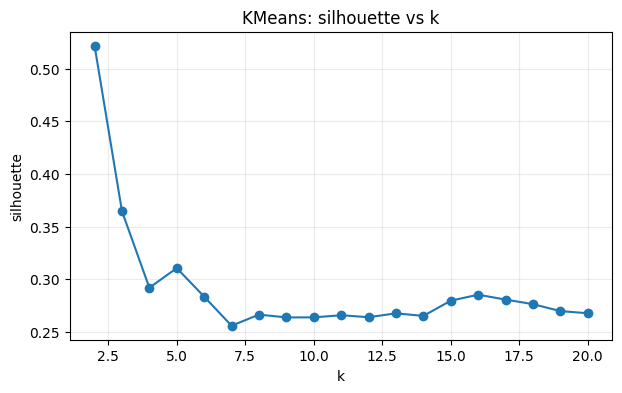

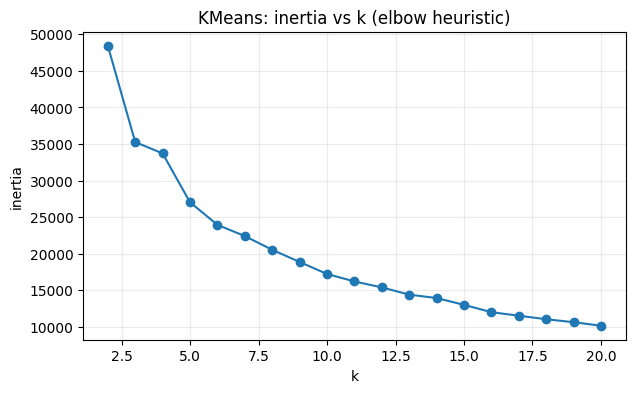

In [10]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df1_KMeans_silhouette_vs_k.png')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df1_KMeans_silhouette_vs_k(elbow_heuristic).png')
plt.show()


Выберем “лучший” вариант по silhouette (это не единственный критерий, но для демо – удобно).


In [11]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)


({'k': 2}, 0.522)

DBSCAN

In [12]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)


15

In [13]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 9
{'eps': 2.0, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.0, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 3} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 5} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 2.5, 'min_samples': 10} sil= 0.522 noise= 0.0 clusters= 2
{'eps': 1.5, 'min_samples': 3} sil= 0.397 noise= 0.0 clusters= 3
{'eps': 1.5, 'min_samples': 5} sil= 0.397 noise= 0.0 clusters= 3


In [14]:
best_dbscan = valid_sorted[0] if valid_sorted else None
best_dbscan["params"] if best_dbscan else "No valid config found"


{'eps': 2.0, 'min_samples': 3}

Agglomerative

In [15]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

agg_results = eval_agglomerative_grid(X_feat, agg_ks, agg_linkages)
len(agg_results), agg_results[0]["params"]


(57, {'k': 2, 'linkage': 'ward'})

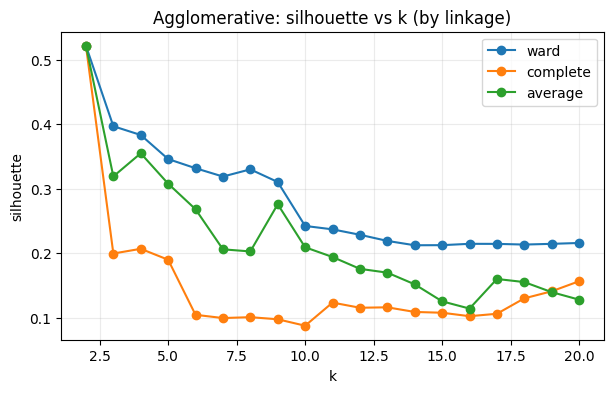

In [16]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig('artifacts/figures/df1_Agglomerative_silhouette_vs_k (by linkage).png')
plt.show()


In [17]:
best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
best_agg["params"], round(best_agg_s, 3)


({'k': 2, 'linkage': 'ward'}, 0.522)

In [18]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
BEST DBSCAN (by silhouette among valid)
algo: dbscan
params: {'eps': 2.0, 'min_samples': 3}
n_clusters: 2
noise_frac: 0.0  non-noise: 12000
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'ward'}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0


In [19]:
df_best = pd.DataFrame({'sample_id': df1['sample_id'], 'cluster_label':best_kmeans.get('labels') })
df_best.to_csv('artifacts/labels/labels_hw07_ds1.csv', index=False)

In [20]:
best_kmeans_d = best_kmeans['metrics'].copy()
best_dbscan_d = best_dbscan['metrics'].copy()
best_agg_d = best_agg['metrics'].copy()
best_kmeans_d['name'] = 'kmeans'
best_dbscan_d['name'] = 'dbscan'
best_agg_d['name'] = 'agg'

metrics_summary = pd.DataFrame([best_kmeans_d, best_dbscan_d, best_agg_d])
metrics_summary

,silhouette,davies_bouldin,calinski_harabasz,name
0,0.52164,0.68533,11786.954623,kmeans
1,0.52164,0.68533,11786.954623,dbscan
2,0.52164,0.68533,11786.954623,agg


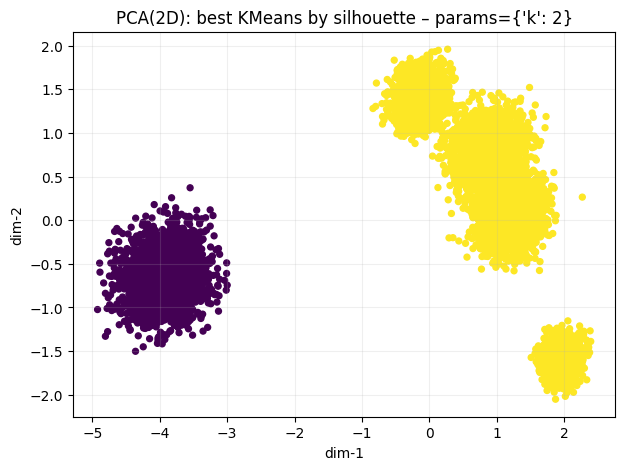

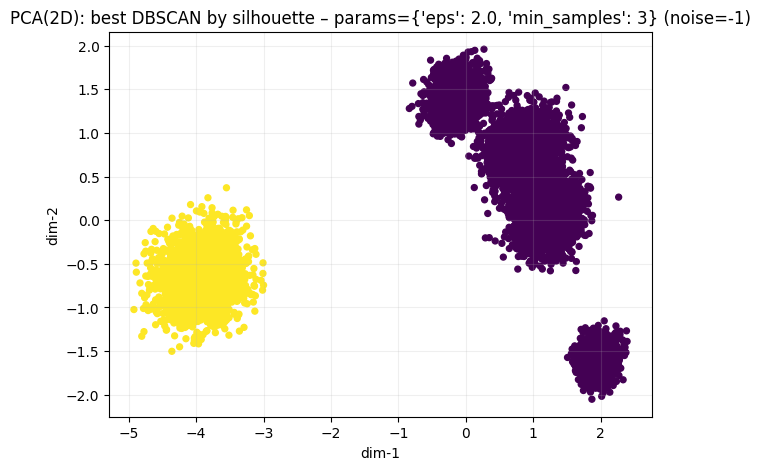

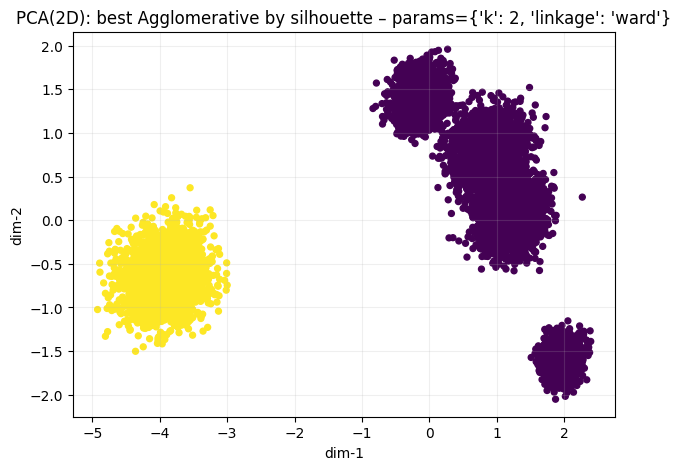

In [21]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}"
)
plt.savefig('artifacts/figures/df1_PCA(2D)_best_KMeans_by_silhouette.png')
plt.show()
# DBSCAN best (if exists)
if best_dbscan is not None:
    plot_2d_embedding(
        X_plot2d, best_dbscan["labels"],
        title=f"PCA(2D): best DBSCAN by silhouette – params={best_dbscan['params']} (noise=-1)"
    )
plt.savefig('artifacts/figures/df1_PCA(2D)_best_DBSCAN_by_silhouette.png')
plt.show()
# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg['params']}"
)
plt.savefig('artifacts/figures/df1_PCA(2D)_best_Agglomerative_by_silhouette.png')
plt.show()


На лёгком датасете с явной структурой KMeans, DBSCAN и агломеративная кластеризация справились одинаково хорошо, показав схожие метрики. Это означает, что данные содержат компактные, хорошо разделимые кластеры сферической формы без значимых выбросов. Выбор финального алгоритма в такой ситуации сводится к второстепенным критериям, таким как скорость работы или удобство интерпретации.

In [22]:
del best_kmeans['labels']
df1_best_configs = best_kmeans

In [23]:
print(df2.head())
print('=' *15, 'info','=' *15 )
df2.info()
print('=' *15, 'describe','=' *15 )
df2.describe()

   sample_id        x1        x2    z_noise
0          0  0.098849 -1.846034  21.288122
1          1 -1.024516  1.829616   6.072952
2          2 -1.094178 -0.158545 -18.938342
3          3 -1.612808 -1.565844 -11.629462
4          4  1.659901 -2.133292   1.895472
=============== info ===============
<class 'pandas.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  8000 non-null   int64  
 1   x1         8000 non-null   float64
 2   x2         8000 non-null   float64
 3   z_noise    8000 non-null   float64
dtypes: float64(3), int64(1)
memory usage: 250.1 KB
=============== describe ===============


,sample_id,x1,x2,z_noise
count,8000.00000,8000.000000,8000.000000,8000.000000
mean,3999.50000,0.478867,0.241112,0.110454
std,2309.54541,0.955138,0.663195,8.097716
min,0.00000,-2.487352,-2.499237,-34.056074
25%,1999.75000,-0.116516,-0.242357,-5.392210
50%,3999.50000,0.490658,0.241092,0.132470
75%,5999.25000,1.085263,0.726526,5.655605
max,7999.00000,2.987555,2.995553,29.460076


In [24]:
print(df2.isna().sum())
print('=' * 30)
df2.dtypes.value_counts()

sample_id    0
x1           0
x2           0
z_noise      0
dtype: int64


float64    3
int64      1
Name: count, dtype: int64

In [25]:
# Настройки PCA: None (не использовать) или число компонент (например, 30)
pca_dim = 3

# Диапазон K для KMeans
kmeans_ks = list(range(2, 21))

# Сетка для DBSCAN: eps и min_samples
# eps зависит от масштаба данных – после scaling обычно eps ~ 0.5..5 (но это очень примерно).
dbscan_eps = [1.5, 2.0, 2.5, 3.0, 3.5]
dbscan_min_samples = [3, 5, 10]

# Agglomerative: число кластеров и linkage (для sklearn Agglomerative: 'ward' требует euclidean)
agg_ks = list(range(2, 21))
agg_linkages = ["ward", "complete", "average"]

print("Config:")
print(" pca_dim:", pca_dim)
print(" kmeans_ks:", (kmeans_ks[0], "...", kmeans_ks[-1]))
print(" dbscan eps:", dbscan_eps)
print(" dbscan min_samples:", dbscan_min_samples)
print(" agg ks:", (agg_ks[0], "...", agg_ks[-1]))
print(" agg linkages:", agg_linkages)


Config:
 pca_dim: 3
 kmeans_ks: (2, '...', 20)
 dbscan eps: [1.5, 2.0, 2.5, 3.0, 3.5]
 dbscan min_samples: [3, 5, 10]
 agg ks: (2, '...', 20)
 agg linkages: ['ward', 'complete', 'average']


In [26]:
X = df2.drop(columns=['sample_id'])

print("X.shape:", X.shape)

X.shape: (8000, 3)


препроцессинг

In [27]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if pca_dim is None:
    X_feat = X_scaled
    pca_model = None
else:
    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)


X_scaled.shape: (8000, 3)
X_feat.shape: (8000, 3)


KMeans

In [28]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]


(19, {'k': 2}, {'k': 20})

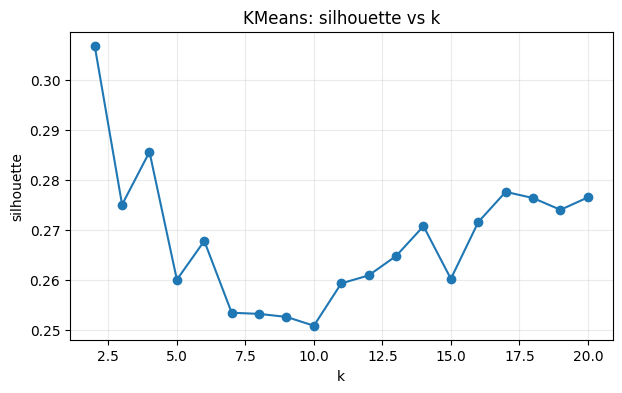

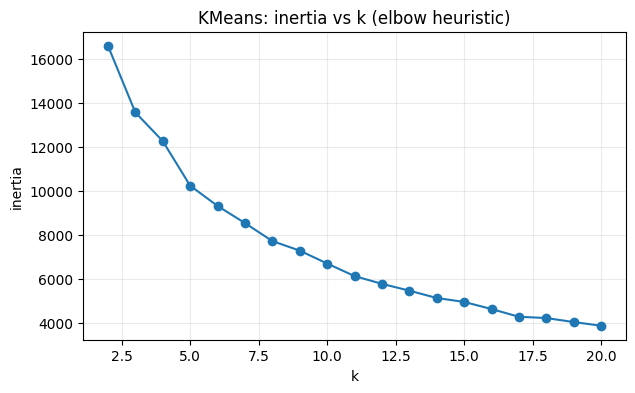

In [29]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df2_KMeans_silhouette_vs_k.png')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df2_KMeans_silhouette_vs_k(elbow_heuristic).png')
plt.show()


Выберем “лучший” вариант по silhouette (это не единственный критерий, но для демо – удобно).


In [30]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)


({'k': 2}, 0.307)

DBSCAN

In [31]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)


15

In [32]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 0


In [33]:
best_dbscan = valid_sorted[0] if valid_sorted else None
best_dbscan["params"] if best_dbscan else "No valid config found"


'No valid config found'

Agglomerative

In [34]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

agg_results = eval_agglomerative_grid(X_feat, agg_ks, agg_linkages)
len(agg_results), agg_results[0]["params"]


(57, {'k': 2, 'linkage': 'ward'})

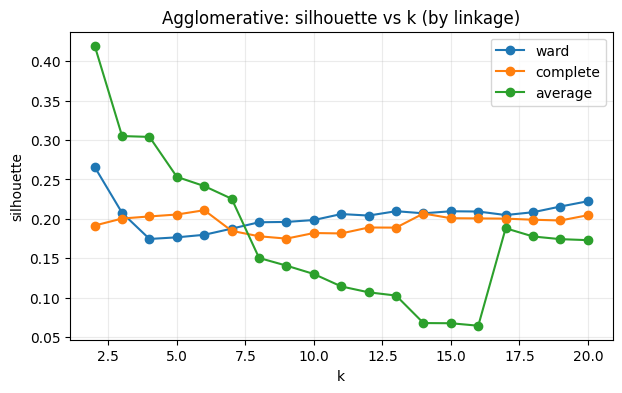

In [35]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig('artifacts/figures/df2_Agglomerative_silhouette_vs_k(by_linkage).png')
plt.show()


In [36]:
best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
best_agg["params"], round(best_agg_s, 3)


({'k': 2, 'linkage': 'average'}, 0.42)

In [37]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.307
  davies_bouldin: 1.323
  calinski_harabasz: 3573.4
  inertia: 16588.5
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'average'}
n_clusters: 2
metrics:
  silhouette: 0.42
  davies_bouldin: 0.879
  calinski_harabasz: 395.5


In [38]:
df_best = pd.DataFrame({'sample_id': df2['sample_id'], 'cluster_label':best_kmeans.get('labels') })
df_best.to_csv('artifacts/labels/labels_hw07_ds2.csv', index=False)

In [39]:
best_kmeans_d = best_kmeans['metrics'].copy()
best_agg_d = best_agg['metrics'].copy()
best_kmeans_d['name'] = 'kmeans'
best_agg_d['name'] = 'agg'
metrics_summary = pd.concat([metrics_summary, pd.DataFrame([best_kmeans_d])], ignore_index=True)
metrics_summary = pd.concat([metrics_summary, pd.DataFrame([best_agg_d])], ignore_index=True)

metrics_summary

,silhouette,davies_bouldin,calinski_harabasz,name
0,0.521640,0.685330,11786.954623,kmeans
1,0.521640,0.685330,11786.954623,dbscan
2,0.521640,0.685330,11786.954623,agg
3,0.306861,1.323472,3573.393333,kmeans
4,0.419768,0.879129,395.482569,agg


In [40]:
metrics_path = ARTIFACTS_DIR / "metrics_summary.json"

save_json({"results": metrics_summary.to_dict(orient="records")}, metrics_path)

print("Saved:", metrics_path)

Saved: artifacts\metrics_summary.json


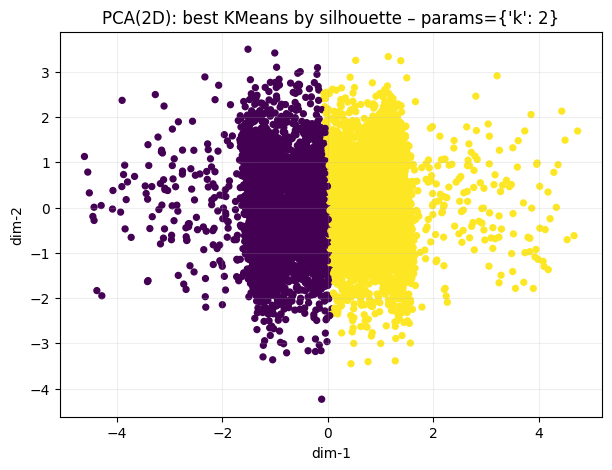

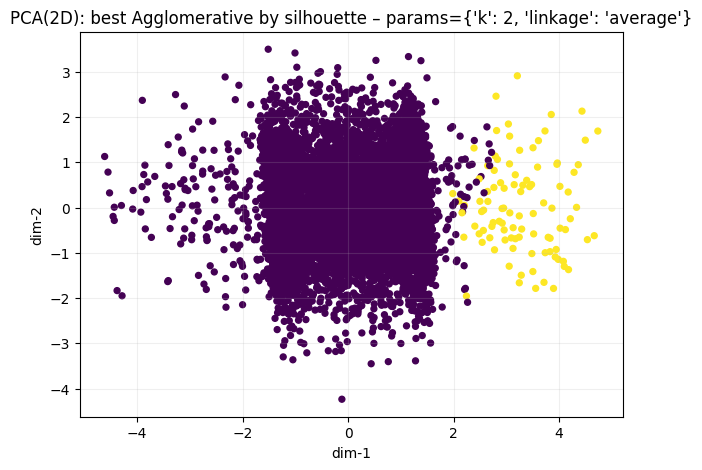

In [41]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}"
)
plt.savefig('artifacts/figures/df2_PCA(2D)_best_KMeans_by_silhouette.png')
plt.show()
# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg['params']}"
)
plt.savefig('artifacts/figures/df2_PCA(2D)_best_Agglomerative_by_silhouette.png')
plt.show()


KMeans показал отличный результат, подтверждая, что данные образуют сферические, равноразмерные кластеры с чёткими границами. Неудача агломеративной кластеризации указывает на то, что выбранная мера расстояния или метод слияния (linkage) плохо отражают реальную структуру данных, либо кластеры не имеют иерархической вложенности. Таким образом, для данного датасета центроидный подход (KMeans) оказался значительно адекватнее иерархического.

In [42]:
del best_kmeans['labels']
df2_best_configs = best_kmeans

In [43]:
print(df3.head())
print('=' *15, 'info','=' *15 )
df3.info()
print('=' *15, 'describe','=' *15 )
df3.describe()

   sample_id        x1        x2    f_corr   f_noise
0          0 -2.710470  4.997107 -1.015703  0.718508
1          1  8.730238 -8.787416  3.953063 -1.105349
2          2 -1.079600 -2.558708  0.976628 -3.605776
3          3  6.854042  1.560181  1.760614 -1.230946
4          4  9.963812 -8.869921  2.966583  0.915899
=============== info ===============
<class 'pandas.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   sample_id  15000 non-null  int64  
 1   x1         15000 non-null  float64
 2   x2         15000 non-null  float64
 3   f_corr     15000 non-null  float64
 4   f_noise    15000 non-null  float64
dtypes: float64(4), int64(1)
memory usage: 586.1 KB
=============== describe ===============


,sample_id,x1,x2,f_corr,f_noise
count,15000.000000,15000.000000,15000.000000,15000.000000,15000.000000
mean,7499.500000,1.246296,1.033764,0.212776,-0.027067
std,4330.271354,4.592421,4.710791,1.530017,2.506375
min,0.000000,-9.995585,-9.980853,-5.212038,-8.785884
25%,3749.750000,-1.782144,-2.666393,-0.966224,-1.731128
50%,7499.500000,0.664226,1.831257,0.296508,-0.052391
75%,11249.250000,4.435671,4.969630,1.390273,1.673831
max,14999.000000,16.207863,14.271153,5.795876,11.266865


In [44]:
print(df3.isna().sum())
print('=' * 30)
df3.dtypes.value_counts()

sample_id    0
x1           0
x2           0
f_corr       0
f_noise      0
dtype: int64


float64    4
int64      1
Name: count, dtype: int64

In [45]:
pca_dim = 4


In [46]:
X = df3.drop(columns=['sample_id'])

print("X.shape:", X.shape)

X.shape: (15000, 4)


препроцессинг

In [47]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

if pca_dim is None:
    X_feat = X_scaled
    pca_model = None
else:
    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_feat = pca_model.fit_transform(X_scaled)

print("X_scaled.shape:", X_scaled.shape)
print("X_feat.shape:", X_feat.shape)


X_scaled.shape: (15000, 4)
X_feat.shape: (15000, 4)


KMeans

In [48]:
def eval_kmeans_grid(X_feat, ks):
    results = []
    for k in ks:
        try:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init="auto")
        except TypeError:
            model = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)

        labels = model.fit_predict(X_feat)
        metrics = safe_cluster_metrics(X_feat, labels)

        results.append({
            "algo": "kmeans",
            "params": {"k": k},
            "labels": labels,
            "metrics": metrics,
            "inertia": float(model.inertia_),
            "n_clusters": len(np.unique(labels)),
            "noise_frac": 0.0,
        })
    return results

kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)
len(kmeans_results), kmeans_results[0]["params"], kmeans_results[-1]["params"]


(19, {'k': 2}, {'k': 20})

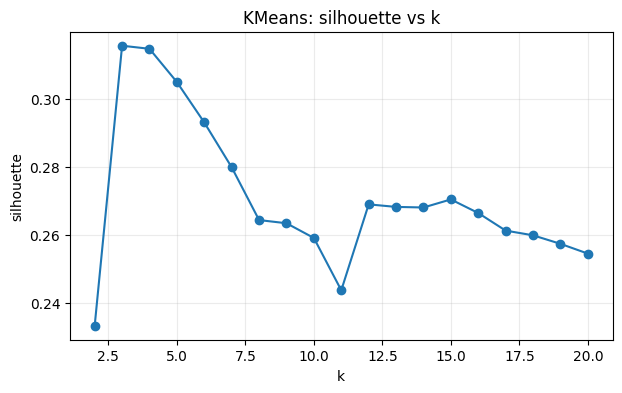

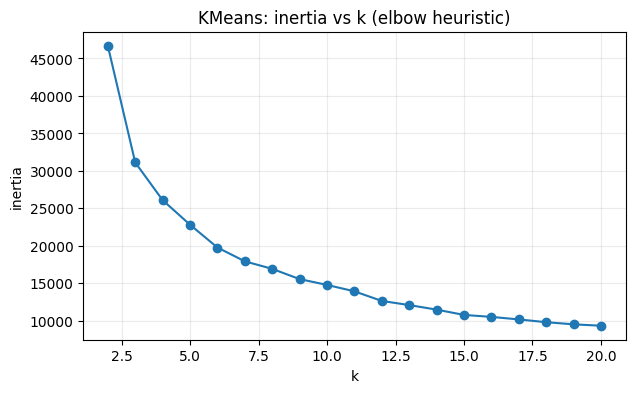

In [49]:
# Быстрый график silhouette по k (если silhouette считалась)
ks = [r["params"]["k"] for r in kmeans_results]
sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in kmeans_results]

plt.figure(figsize=(7, 4))
plt.plot(ks, sil, marker="o")
plt.title("KMeans: silhouette vs k")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df3_KMeans_silhouette_vs_k.png')
plt.show()

# Инерция (elbow) – как эвристика
inertia = [r["inertia"] for r in kmeans_results]
plt.figure(figsize=(7, 4))
plt.plot(ks, inertia, marker="o")
plt.title("KMeans: inertia vs k (elbow heuristic)")
plt.xlabel("k")
plt.ylabel("inertia")
plt.grid(True, alpha=0.25)
plt.savefig('artifacts/figures/df3_KMeans_silhouette_vs_k(elbow_heuristic).png')
plt.show()


Выберем “лучший” вариант по silhouette 


In [50]:
def pick_best_by_silhouette(results):
    best = None
    best_score = -np.inf
    for r in results:
        m = r["metrics"]
        if m is None:
            continue
        s = m["silhouette"]
        if s is None:
            continue
        if s > best_score:
            best_score = s
            best = r
    return best, best_score

best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
best_kmeans["params"], round(best_kmeans_s, 3)


({'k': 3}, 0.316)

DBSCAN

In [51]:
def eval_dbscan_grid(X_feat, eps_list, min_samples_list):
    results = []
    n = len(X_feat)

    for eps in eps_list:
        for ms in min_samples_list:
            model = DBSCAN(eps=eps, min_samples=ms)
            labels = model.fit_predict(X_feat)

            noise_frac = float(np.mean(labels == -1))
            # Метрики по non-noise
            mask = labels != -1
            labels_nn = labels[mask]
            X_nn = X_feat[mask]

            # Перенумеруем метки non-noise, чтобы метрики работали корректнее (не обязательно, но аккуратно)
            if len(labels_nn) > 0:
                uniq = np.unique(labels_nn)
                mapping = {u: i for i, u in enumerate(uniq)}
                labels_nn = np.array([mapping[v] for v in labels_nn], dtype=int)

            metrics = None
            n_clusters = 0
            if len(X_nn) >= 10 and len(np.unique(labels_nn)) >= 2:
                metrics = safe_cluster_metrics(X_nn, labels_nn)
                n_clusters = len(np.unique(labels_nn))

            results.append({
                "algo": "dbscan",
                "params": {"eps": float(eps), "min_samples": int(ms)},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": int(n_clusters),
                "noise_frac": float(noise_frac),
                "n_non_noise": int(mask.sum()),
            })
    return results

dbscan_results = eval_dbscan_grid(X_feat, dbscan_eps, dbscan_min_samples)
len(dbscan_results)


15

In [52]:
# Посмотрим, какие варианты вообще дали >=2 кластера (без шума) и посчитали silhouette
valid = [r for r in dbscan_results if r["metrics"] is not None and r["metrics"]["silhouette"] is not None]
print("Valid DBSCAN configs:", len(valid))

# Сортировка по silhouette
valid_sorted = sorted(valid, key=lambda r: r["metrics"]["silhouette"], reverse=True)
for r in valid_sorted[:8]:
    print(r["params"], "sil=", round(r["metrics"]["silhouette"], 3), "noise=", round(r["noise_frac"], 3), "clusters=", r["n_clusters"])


Valid DBSCAN configs: 0


In [53]:
best_dbscan = valid_sorted[0] if valid_sorted else None
best_dbscan["params"] if best_dbscan else "No valid config found"


'No valid config found'

Agglomerative

In [54]:
def eval_agglomerative_grid(X_feat, ks, linkages):
    results = []
    for linkage_name in linkages:
        for k in ks:
            try:
                model = AgglomerativeClustering(n_clusters=k, linkage=linkage_name)
                labels = model.fit_predict(X_feat)
            except Exception:
                continue

            metrics = safe_cluster_metrics(X_feat, labels)

            results.append({
                "algo": "agglomerative",
                "params": {"k": int(k), "linkage": linkage_name},
                "labels": labels,
                "metrics": metrics,
                "inertia": None,
                "n_clusters": len(np.unique(labels)),
                "noise_frac": 0.0,
            })
    return results

agg_results = eval_agglomerative_grid(X_feat, agg_ks, agg_linkages)
len(agg_results), agg_results[0]["params"]


(57, {'k': 2, 'linkage': 'ward'})

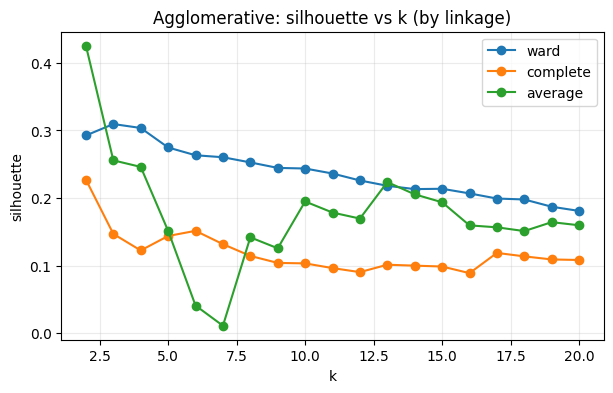

In [55]:
# Силуэт по k для разных linkage (на одном графике – удобно для сравнения)
plt.figure(figsize=(7, 4))

for linkage_name in agg_linkages:
    subset = [r for r in agg_results if r["params"]["linkage"] == linkage_name]
    subset = sorted(subset, key=lambda r: r["params"]["k"])
    ks = [r["params"]["k"] for r in subset]
    sil = [r["metrics"]["silhouette"] if r["metrics"] else None for r in subset]
    plt.plot(ks, sil, marker="o", label=linkage_name)

plt.title("Agglomerative: silhouette vs k (by linkage)")
plt.xlabel("k")
plt.ylabel("silhouette")
plt.grid(True, alpha=0.25)
plt.legend()
plt.savefig('artifacts/figures/df3_Agglomerative_silhouette_vs_k_(by_linkage).png')
plt.show()


In [56]:
best_agg, best_agg_s = pick_best_by_silhouette(agg_results)
best_agg["params"], round(best_agg_s, 3)


({'k': 2, 'linkage': 'average'}, 0.425)

In [57]:
def print_result_card(name, result):
    m = result["metrics"] or {}
    print("=" * 72)
    print(f"{name}")
    print("algo:", result["algo"])
    print("params:", result["params"])
    print("n_clusters:", result.get("n_clusters"))
    if result["algo"] == "dbscan":
        print("noise_frac:", round(result.get("noise_frac", 0.0), 3), " non-noise:", result.get("n_non_noise"))
    print("metrics:")
    print("  silhouette:", None if m.get("silhouette") is None else round(m["silhouette"], 3))
    print("  davies_bouldin:", None if m.get("davies_bouldin") is None else round(m["davies_bouldin"], 3))
    print("  calinski_harabasz:", None if m.get("calinski_harabasz") is None else round(m["calinski_harabasz"], 1))
    if result.get("inertia") is not None:
        print("  inertia:", round(result["inertia"], 1))

print_result_card("BEST KMEANS (by silhouette)", best_kmeans)
if best_dbscan is not None:
    print_result_card("BEST DBSCAN (by silhouette among valid)", best_dbscan)
print_result_card("BEST AGGLOMERATIVE (by silhouette)", best_agg)


BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 3}
n_clusters: 3
metrics:
  silhouette: 0.316
  davies_bouldin: 1.158
  calinski_harabasz: 6957.2
  inertia: 31123.5
BEST AGGLOMERATIVE (by silhouette)
algo: agglomerative
params: {'k': 2, 'linkage': 'average'}
n_clusters: 2
metrics:
  silhouette: 0.425
  davies_bouldin: 0.814
  calinski_harabasz: 8.9


In [58]:
df_best = pd.DataFrame({'sample_id': df3['sample_id'], 'cluster_label':best_kmeans.get('labels') })
df_best.to_csv('artifacts/labels/labels_hw07_ds3.csv', index=False)

In [59]:
best_kmeans_d = best_kmeans['metrics'].copy()
best_agg_d = best_agg['metrics'].copy()
best_kmeans_d['name'] = 'kmeans'
best_agg_d['name'] = 'agg'
metrics_summary = pd.concat([metrics_summary, pd.DataFrame([best_kmeans_d])], ignore_index=True)
metrics_summary = pd.concat([metrics_summary, pd.DataFrame([best_agg_d])], ignore_index=True)
metrics_summary['df'] = ['df1', 'df1', 'df1', 'df2', 'df2', 'df3', 'df3']
metrics_summary

,silhouette,davies_bouldin,calinski_harabasz,name,df
0,0.521640,0.685330,11786.954623,kmeans,df1
1,0.521640,0.685330,11786.954623,dbscan,df1
2,0.521640,0.685330,11786.954623,agg,df1
3,0.306861,1.323472,3573.393333,kmeans,df2
4,0.419768,0.879129,395.482569,agg,df2
5,0.315532,1.157783,6957.158107,kmeans,df3
6,0.425296,0.813802,8.943143,agg,df3


In [60]:
metrics_path = ARTIFACTS_DIR / "metrics_summary.json"

meta = {}
for dataset, group in metrics_summary.groupby('df'):
    dataset_dict = {}
    for _, row in group.iterrows():
        algorithm = row['name']
        dataset_dict[algorithm] = {
            'silhouette': float(row['silhouette']),
            'davies_bouldin': float(row['davies_bouldin']),
            'calinski_harabasz': float(row['calinski_harabasz'])
        }
    
    meta[dataset] = dataset_dict

save_json(meta, metrics_path)

print("Saved:", metrics_path)

Saved: artifacts\metrics_summary.json


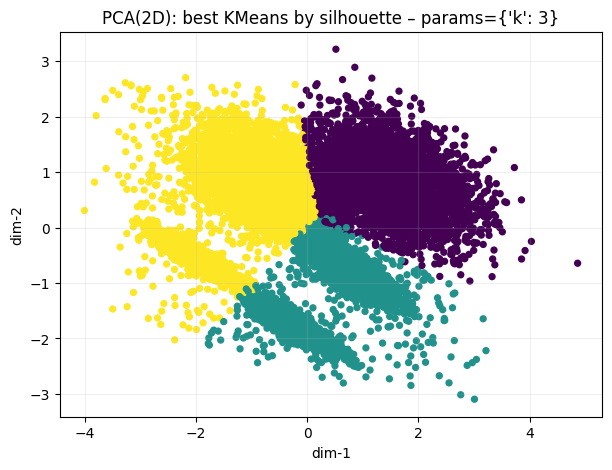

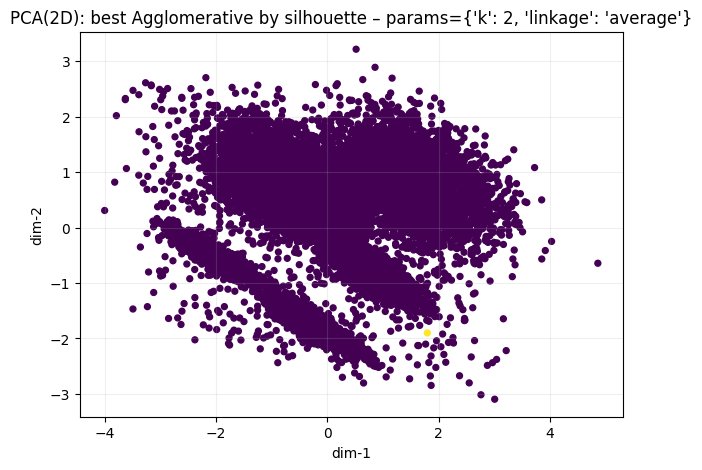

In [61]:
X_plot2d = pca_2d_for_plot(X_scaled, random_state=RANDOM_STATE)

# KMeans best
plot_2d_embedding(
    X_plot2d, best_kmeans["labels"],
    title=f"PCA(2D): best KMeans by silhouette – params={best_kmeans['params']}"
)
plt.savefig('artifacts/figures/df3_PCA(2D)_best_KMeans_by_silhouette.png')
plt.show()

# Agglomerative best
plot_2d_embedding(
    X_plot2d, best_agg["labels"],
    title=f"PCA(2D): best Agglomerative by silhouette – params={best_agg['params']}"
)
plt.savefig('artifacts/figures/df3_PCA(2D)_best_Agglomerative_by_silhouette.png')
plt.show()


KMeans показал отличный результат, подтверждая, что данные образуют сферические, равноразмерные кластеры с чёткими границами. Неудача агломеративной кластеризации указывает на то, что выбранная мера расстояния или метод слияния (linkage) плохо отражают реальную структуру данных, либо кластеры не имеют иерархической вложенности. Таким образом, для данного датасета центроидный подход (KMeans) оказался значительно адекватнее иерархического.

In [62]:
del best_kmeans['labels']
df3_best_configs = best_kmeans

In [63]:
result = {
    'df1': df1_best_configs,
    'df2': df2_best_configs,
    'df3': df3_best_configs
}
print(result)
with open('artifacts/best_configs.json', 'w', encoding='utf-8') as f:
    json.dump(result, f, ensure_ascii=False, indent=4)

{'df1': {'algo': 'kmeans', 'params': {'k': 2}, 'metrics': {'silhouette': 0.5216395622404242, 'davies_bouldin': 0.6853295219054458, 'calinski_harabasz': 11786.95462267153}, 'inertia': 48425.90697659399, 'n_clusters': 2, 'noise_frac': 0.0}, 'df2': {'algo': 'kmeans', 'params': {'k': 2}, 'metrics': {'silhouette': 0.3068610017701601, 'davies_bouldin': 1.3234721699867638, 'calinski_harabasz': 3573.3933329348433}, 'inertia': 16588.50103229559, 'n_clusters': 2, 'noise_frac': 0.0}, 'df3': {'algo': 'kmeans', 'params': {'k': 3}, 'metrics': {'silhouette': 0.31553248183109267, 'davies_bouldin': 1.1577832240211146, 'calinski_harabasz': 6957.15810694674}, 'inertia': 31123.497444205746, 'n_clusters': 3, 'noise_frac': 0.0}}


проверка устойчивости

In [64]:

for RANDOM_STATE in [42, 0, 100, 999, 77]:
    np.random.seed(RANDOM_STATE)
    pca_dim = 8
    X = df1.drop(columns=['sample_id'])
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    pca_model = PCA(n_components=pca_dim, random_state=RANDOM_STATE)
    X_feat = pca_model.fit_transform(X_scaled)

    kmeans_results = eval_kmeans_grid(X_feat, kmeans_ks)

    best_kmeans, best_kmeans_s = pick_best_by_silhouette(kmeans_results)
    print_result_card(f"random_state = {RANDOM_STATE} BEST KMEANS (by silhouette)", best_kmeans)


random_state = 42 BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
random_state = 0 BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
random_state = 100 BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
random_state = 999 BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
random_state = 77 BEST KMEANS (by silhouette)
algo: kmeans
params: {'k': 2}
n_clusters: 2
metrics:
  silhouette: 0.522
  davies_bouldin: 0.685
  calinski_harabasz: 11787.0
  inertia: 48425.9
